* Day Count Convention	30/360
* O/N Leg Frequency	Daily
* Fixed Leg Frequency	Annual


In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# handy it seems
# https://docs.sympy.org/latest/modules/solvers/solvers.html
from sympy.solvers import solve
from sympy import Symbol


# read data
ois_data = pd.read_csv("../data/OIS_Data.csv")
irs_data = pd.read_csv("../data/IRS_Data.csv")
ois_data.columns = map(str.lower, ois_data.columns)
irs_data.columns = map(str.lower, irs_data.columns)

# use dict comprehension?
tenor_mapping = {
    "6m": 0.5,
    "1y": 1,
    "2y": 2,
    "3y": 3,
    "4y": 4,
    "5y": 5,
    "7y": 7,
    "10y": 10,
    "15y": 15,
    "20y": 20,
    "30y": 30,
}

# OIS processing
ois_data["tenor"] = ois_data["tenor"].map(tenor_mapping)
ois_data["rate"] = ois_data["rate"].str.strip("%").astype(float) / 100.0

# DAY COUNT CONVENTION IS 30/360
FULL_YEAR = 360

In [17]:
ois_data['tenor_diff'] = ois_data['tenor'] - ois_data['tenor'].shift() 

In [18]:
ois_data

,tenor,product,rate,tenor_diff
0,0.5,OIS,0.00250,NaN
1,1.0,OIS,0.00300,0.5
2,2.0,OIS,0.00325,1.0
3,3.0,OIS,0.00335,1.0
4,4.0,OIS,0.00350,1.0
5,5.0,OIS,0.00360,1.0
6,7.0,OIS,0.00400,2.0
7,10.0,OIS,0.00450,3.0
8,15.0,OIS,0.00500,5.0
9,20.0,OIS,0.00525,5.0


##  solve for < 1 y stuff ##

Because these 2 are anchors i believe

In [19]:
f_6m = Symbol("f_6m")
f_6m = solve((1 + 0.5 * ois_data.loc[0, "rate"]) ** (1 / 180) - (1 + f_6m / 360))[0]
print(f_6m)

0.00249844747059136


In [20]:
f_1y = Symbol("f_1y")
f_1y = solve(
    ((1 + 1 * ois_data.loc[1, "rate"]) / (1 + f_6m / 360) ** 180) ** (1 / 180)
    - (1 + f_1y / 360)
)[0]
print(f_1y)

0.00349259610064934


In [21]:
ois_data.loc[0, "disc_factor"] = 1 / (1 + f_6m / 360) ** 180
ois_data.loc[1, "disc_factor"] = 1 / (
    ((1 + f_6m / 360) ** 180) * ((1 + f_1y / 360) ** 180)
)

/tmp/ipykernel_3144/1376100111.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.998751560549318' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ois_data.loc[0, "disc_factor"] = 1 / (1 + f_6m / 360) ** 180


In [22]:
ois_data

,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,NaN
3,3.0,OIS,0.00335,1.0,NaN
4,4.0,OIS,0.00350,1.0,NaN
5,5.0,OIS,0.00360,1.0,NaN
6,7.0,OIS,0.00400,2.0,NaN
7,10.0,OIS,0.00450,3.0,NaN
8,15.0,OIS,0.00500,5.0,NaN
9,20.0,OIS,0.00525,5.0,NaN


## Let's try the collapsing shit, thx eko ##
I can test up until 5 first

In [23]:
y_1_funny = (
    ((1 + f_6m / 360) ** 180)
    * ((1 + f_1y / 360) ** 180)
    * ois_data.loc[1, "disc_factor"]
)
# youd be surprised
print(y_1_funny)

1.00000000000000


In [24]:
for k in range(2, 6):
    denominator = 1 / (1 + 1 * ois_data.loc[k, "rate"])
    sum_prev_disc_rate = ois_data.loc[1:k, "disc_factor"].sum()
    print(sum_prev_disc_rate)
    numerator = y_1_funny - 1 * ois_data.loc[k, "rate"] * sum_prev_disc_rate
    ois_data.loc[k, "disc_factor"] = numerator * denominator

0.997008973080741
1.99053971899401
2.98055486021230
3.96667150992755


In [25]:
ois_data

,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,0.993530745913270
3,3.0,OIS,0.00335,1.0,0.990015141218289
4,4.0,OIS,0.00350,1.0,0.986116649715253
5,5.0,OIS,0.00360,1.0,0.982184119733221
6,7.0,OIS,0.00400,2.0,NaN
7,10.0,OIS,0.00450,3.0,NaN
8,15.0,OIS,0.00500,5.0,NaN
9,20.0,OIS,0.00525,5.0,NaN


## interpolation required ##

In [26]:
previous_disc_factors = ois_data.loc[1:5,"disc_factor"].to_numpy()
print(previous_disc_factors)

[0.997008973080741 0.993530745913270 0.990015141218289 0.986116649715253
 0.982184119733221]


In [27]:
# k = 6 to 10
for k in range(6,11):
    mul_fact = 1.0/ois_data.loc[k,'tenor_diff']
    rate = ois_data.loc[k, "rate"]
    max_sum = sum(range(1,int(ois_data.loc[k,'tenor_diff'])))
    print(f"{mul_fact} * {max_sum} = {mul_fact * max_sum}")
    denominator = 1 / (1 + 1 * rate * (2 + mul_fact * max_sum))

    # up till now how many disc factors do we have
    sum_prev_disc_rate = previous_disc_factors.sum()
    # add the interpolation point
    sum_prev_disc_rate += (1 - mul_fact * max_sum) * ois_data.loc[k - 1, "disc_factor"]
    
    numerator = y_1_funny - 1 * ois_data.loc[k, "rate"] * sum_prev_disc_rate
    ois_data.loc[k, "disc_factor"] = numerator * denominator

    # find points between
    interpolated_disc_factors = []
    diff_factor = mul_fact * (ois_data.loc[k, "disc_factor"] - ois_data.loc[k-1, "disc_factor"]) 

    for x in range(1,int(ois_data.loc[k,'tenor_diff'])):
        to_append = ois_data.loc[k-1, "disc_factor"] + diff_factor * x
        print(f"{x} = {to_append}")
        interpolated_disc_factors.append(to_append)
    # append them
    previous_disc_factors = np.append(previous_disc_factors, interpolated_disc_factors)
    previous_disc_factors = np.append(previous_disc_factors, ois_data.loc[k, "disc_factor"])


0.5 * 1 = 0.5
1 = 0.975369391174477
0.3333333333333333 * 3 = 1.0
1 = 0.964394932592193
2 = 0.960235202568652
0.2 * 10 = 2.0
1 = 0.952294289978627
2 = 0.948513107412142
3 = 0.944731924845657
4 = 0.940950742279172
0.2 * 10 = 2.0
1 = 0.931676907198694
2 = 0.926184254684701
3 = 0.920691602170708
4 = 0.915198949656715
0.1 * 45 = 4.5
1 = 0.906832073909327
2 = 0.903957850675932
3 = 0.901083627442537
4 = 0.898209404209142
5 = 0.895335180975746
6 = 0.892460957742351
7 = 0.889586734508956
8 = 0.886712511275561
9 = 0.883838288042166


In [28]:
ois_data


,tenor,product,rate,tenor_diff,disc_factor
0,0.5,OIS,0.00250,NaN,0.998751560549318
1,1.0,OIS,0.00300,0.5,0.997008973080741
2,2.0,OIS,0.00325,1.0,0.993530745913270
3,3.0,OIS,0.00335,1.0,0.990015141218289
4,4.0,OIS,0.00350,1.0,0.986116649715253
5,5.0,OIS,0.00360,1.0,0.982184119733221
6,7.0,OIS,0.00400,2.0,0.968554662615733
7,10.0,OIS,0.00450,3.0,0.956075472545111
8,15.0,OIS,0.00500,5.0,0.937169559712687
9,20.0,OIS,0.00525,5.0,0.909706297142722


([<matplotlib.axis.XTick at 0x7f3908be9ba0>,
 [Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(2.0, 0, '2.0'),
  Text(3.0, 0, '3.0'),
  Text(4.0, 0, '4.0'),
  Text(5.0, 0, '5.0'),
  Text(7.0, 0, '7.0'),
  Text(10.0, 0, '10.0'),
  Text(15.0, 0, '15.0'),
  Text(20.0, 0, '20.0'),
  Text(30.0, 0, '30.0')])

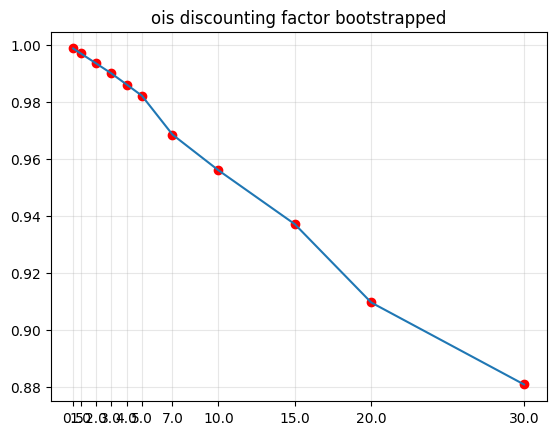

In [29]:
plt.title('ois discounting factor bootstrapped')
plt.grid(alpha=0.3)
plt.plot(ois_data['tenor'],ois_data['disc_factor'],'ro')
plt.plot(ois_data['tenor'],ois_data['disc_factor'])
plt.xticks(ois_data['tenor'])

In [30]:
final_disc_factor_annual  = pd.DataFrame([range(1,31),previous_disc_factors]).T

In [31]:
final_disc_factor_annual

,0,1
0,1,0.997008973080741
1,2,0.993530745913270
2,3,0.990015141218289
3,4,0.986116649715253
4,5,0.982184119733221
5,6,0.975369391174477
6,7,0.968554662615733
7,8,0.964394932592193
8,9,0.960235202568652
9,10,0.956075472545111
